# MolFormer Fine-tuning: Masked Language Modeling and Regression

The goal is to fine-tune a pre-trained chemical language model on a regression task using the Lipophilicity dataset. The task involves predicting the lipophilicity value for a given molecule representation (SMILES string). You will learn how to load and tokenize a dataset from HuggingFace, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
from google.colab import drive
# drive.mount('/content/drive/')# Note: Commented out for local execution. Uncomment if using Google Colab.


Mounted at /content/drive/


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.1 MB/s eta 0:00:00


In [3]:
# import dependencies
import torch
from datasets import load_dataset
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AutoModelForMaskedLM, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm.notebook import tqdm
import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# 1.Fine-tune a Chemical Language Model on Lipophilicity


## --- Step 1: Load Dataset ---

The dataset we are going to use is the [Lipophilicity](https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_Lipophilicity) dataset, part of [MoleculeNet](https://pubs.rsc.org/en/content/articlelanding/2018/sc/c7sc02664a) benchmark.

Lipophilicity, also known as hydrophobicity, is a measure of how readily a substance dissolves in nonpolar solvents (such as oil) compared to polar solvents (such as water).

In [4]:
# specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  #MoLFormer model

In [5]:
# load the dataset from HuggingFace
dataset = load_dataset(DATASET_PATH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

lipophilicity.csv:   0%|          | 0.00/223k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [6]:
# Explore the dataset
# For example, print the column names and display a few sample rows
df = pd.DataFrame(dataset['train'])
# Display column names and a few rows
print("Column Names:", df.columns)
print("\nSample Rows:")
print(df.head())

# Data types and null values
print("\nData Types:")
print(df.dtypes)

print("\nNull Value Counts:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for duplicate rows
print("\nDuplicate Rows:", df.duplicated().sum())

Column Names: Index(['SMILES', 'label'], dtype='object')

Sample Rows:
                                              SMILES  label
0            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   3.54
1  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...  -1.18
2             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   3.69
3  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   3.37
4  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   3.10

Data Types:
SMILES     object
label     float64
dtype: object

Null Value Counts:
SMILES    0
label     0
dtype: int64

Summary Statistics:
             label
count  4200.000000
mean      2.186336
std       1.203004
min      -1.500000
25%       1.410000
50%       2.360000
75%       3.100000
max       4.500000

Duplicate Rows: 0



Unique values in 'SMILES': 4200
SMILES
CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N                           1
Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14                      1
COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23    1
COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl                       1
OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3     1
Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)NCC#N)c1        1
OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4                         1
COc1cc(OC)c(cc1NC(=O)CCC(=O)O)S(=O)(=O)NCc2ccccc2N3CCCCC3    1
CCOc1ccccc1CNCc2cccc(CCNC[C@H](O)c3ccc(O)c4NC(=O)Sc34)c2     1
CCCCNc1cc(cc(c1Oc2ccccc2)S(=O)(=O)N)C(=O)O                   1
Name: count, dtype: int64


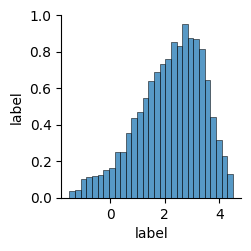

In [7]:
# Explore the target variable (if available)
if 'y' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(df['y'], kde=True, bins=30, color='blue')
    plt.title("Distribution of Target Variable (y)")
    plt.xlabel("y")
    plt.ylabel("Frequency")
    plt.show()

# Analyze categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")
    print(df[col].value_counts().head(10))  # Display top 10 frequent values

# Pair plot for numerical relationships (if at least 1 numerical column exists)
numerical_cols = df.select_dtypes(include=['float', 'int']).columns
if len(numerical_cols) > 0:
    sns.pairplot(df[numerical_cols])
    plt.show()
else:
    print("\nNo numerical columns to analyze for relationships.")

In [8]:
# Pair plot (if there are numerical features)
if len(df.select_dtypes(include=['float', 'int']).columns) > 1:
    sns.pairplot(df.select_dtypes(include=['float', 'int']))
    plt.show()

# Count unique entries for categorical variables
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{col}': {df[col].nunique()}")
    print(df[col].value_counts())

# Save the DataFrame to a CSV file for further exploration if needed
df.to_csv("MoleculeNet_Lipophilicity.csv", index=False)
print("\nDataset saved as 'MoleculeNet_Lipophilicity.csv'.")


Unique values in 'SMILES': 4200
SMILES
CN1C(=O)C=C(CCc2ccc3ccccc3c2)N=C1N                           1
Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14                      1
COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23    1
COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl                       1
OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3     1
                                                            ..
C[C@H](Nc1nc(Nc2cc(C)[nH]n2)c(C)nc1C#N)c3ccc(F)cn3           1
O=C1CCCCCN1                                                  1
CCCSc1ncccc1C(=O)N2CCCC2c3ccncc3                             1
CC1CCCCC1NC(=O)c2cnn(c2NS(=O)(=O)c3ccc(C)cc3)c4ccccc4        1
Nc1ccc(cc1)c2nc3ccc(O)cc3s2                                  1
Name: count, Length: 4200, dtype: int64

Dataset saved as 'MoleculeNet_Lipophilicity.csv'.


First few rows of 'label':
0    3.54
1   -1.18
2    3.69
3    3.37
4    3.10
Name: label, dtype: float64


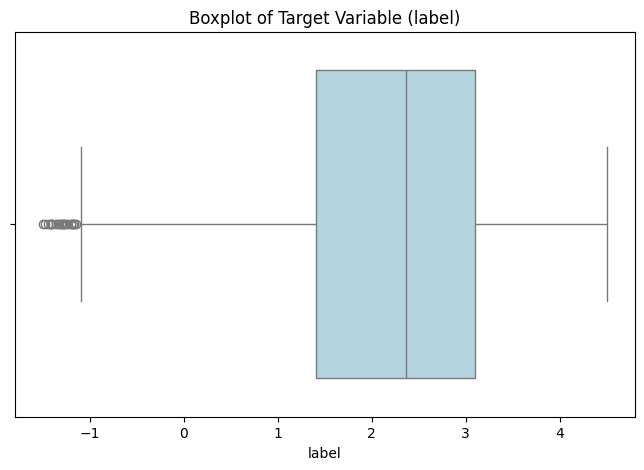

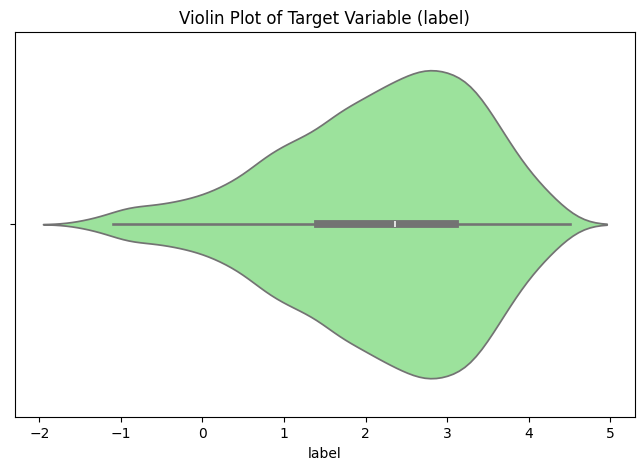

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check the column names
target_column = 'label'  # Update the target column name

# Ensure the target column exists and is valid
if target_column in df.columns:
    print(f"First few rows of '{target_column}':")
    print(df[target_column].head())

    # Boxplot for the target variable
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[target_column], color='lightblue')
    plt.title(f"Boxplot of Target Variable ({target_column})")
    plt.xlabel(target_column)
    plt.show()

    # Violin plot for the target variable
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=df[target_column], color='lightgreen')
    plt.title(f"Violin Plot of Target Variable ({target_column})")
    plt.xlabel(target_column)
    plt.show()
else:
    print(f"Column '{target_column}' not found in the dataset.")


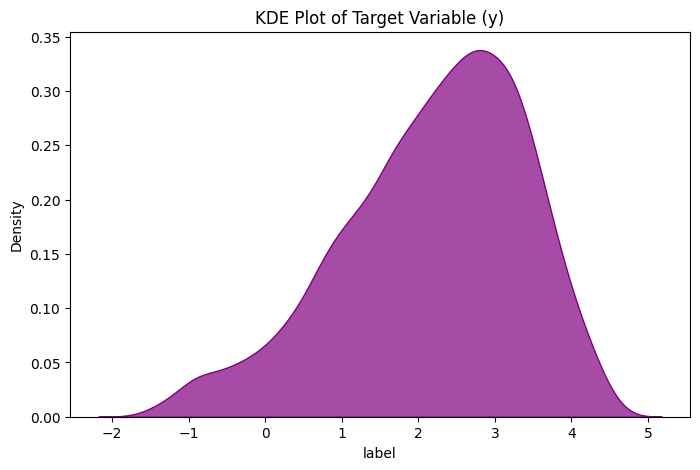

In [11]:
if 'label' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(df['label'], fill=True, color='purple', alpha=0.7)
    plt.title("KDE Plot of Target Variable (y)")
    plt.xlabel("label")
    plt.ylabel("Density")
    plt.show()


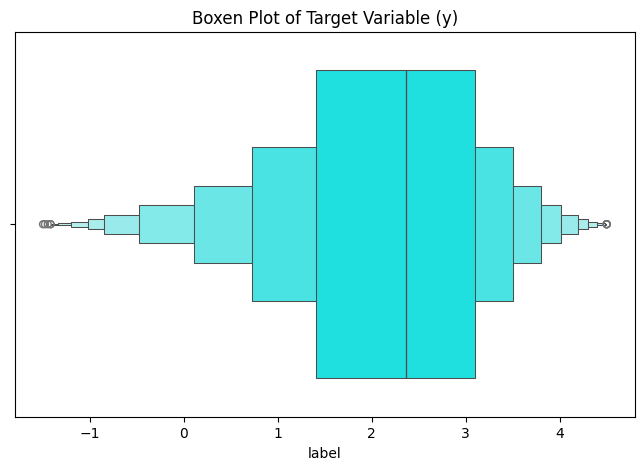

In [12]:
if 'label' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.boxenplot(x=df['label'], color='cyan')
    plt.title("Boxen Plot of Target Variable (y)")
    plt.xlabel("label")
    plt.show()

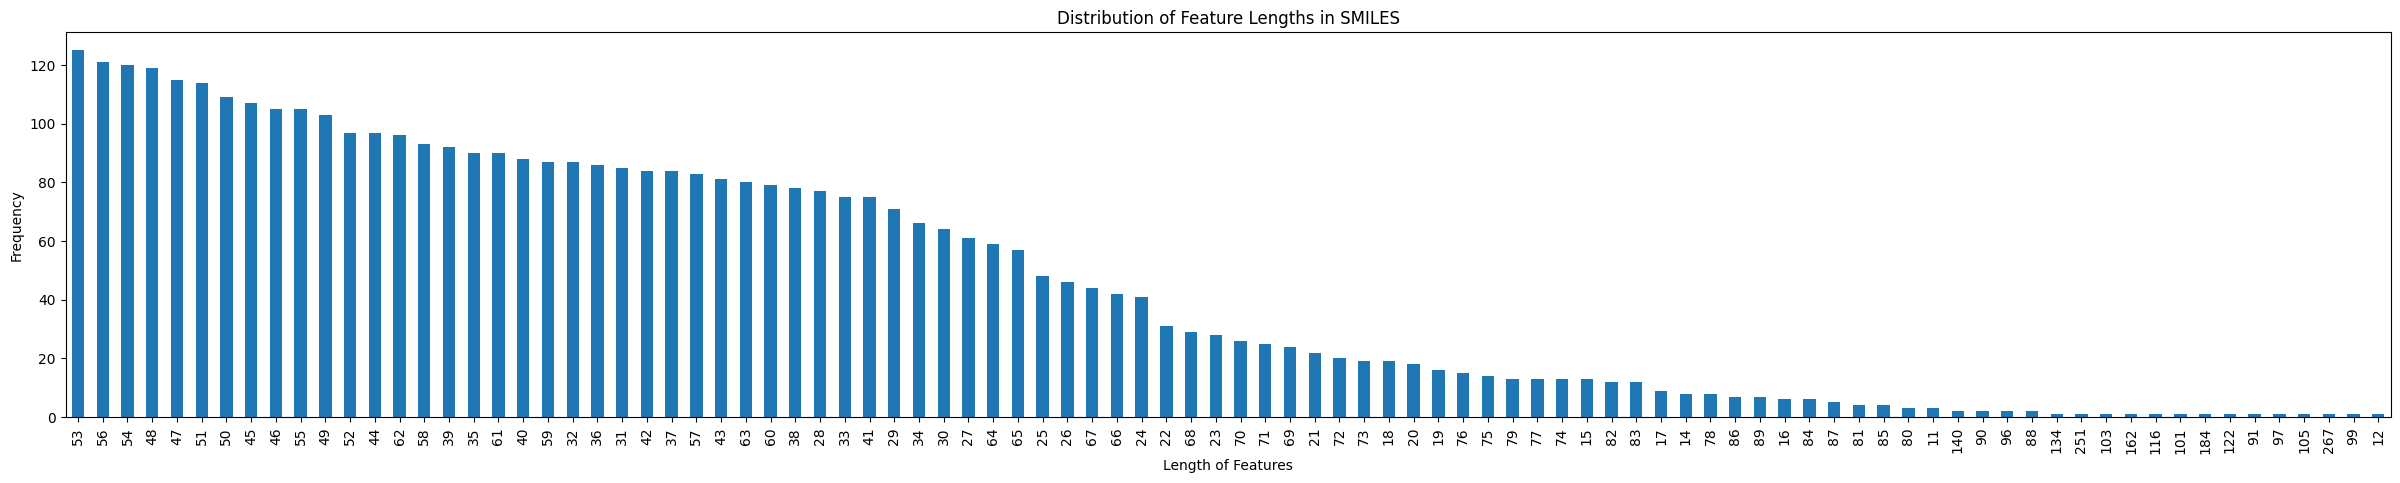

In [13]:
for col in categorical_cols:
    plt.figure(figsize=(30, 5))
    df[col].str.len().value_counts().plot(kind='bar')
    plt.title(f"Distribution of Feature Lengths in {col}")
    plt.xlabel("Length of Features")
    plt.ylabel("Frequency")
    plt.show()

In [14]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 24.2 MB/s eta 0:00:00


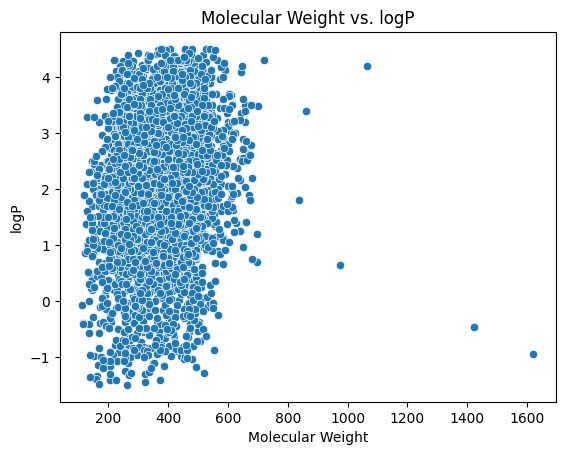

In [15]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# Calculate molecular weight for each molecule
mol_weights = [Descriptors.MolWt(Chem.MolFromSmiles(smiles)) for smiles in dataset['train']['SMILES']]

# Scatter plot
sns.scatterplot(x=mol_weights, y=dataset['train']['label'])
plt.title('Molecular Weight vs. logP')
plt.xlabel('Molecular Weight')
plt.ylabel('logP')
plt.show()

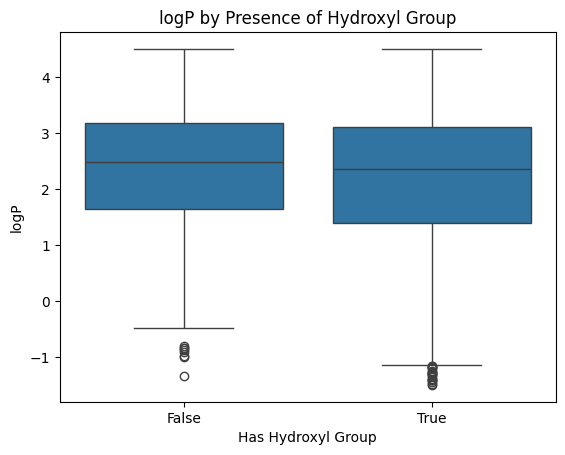

In [16]:
from rdkit import Chem

# Define a function to check for a specific fragment (e.g., hydroxyl group)
def has_fragment(smiles, fragment_smiles):
    mol = Chem.MolFromSmiles(smiles)
    fragment = Chem.MolFromSmiles(fragment_smiles)
    return mol.HasSubstructMatch(fragment)

# Add a column for hydroxyl group presence
has_hydroxyl = [has_fragment(smiles, 'O') for smiles in dataset['train']['SMILES']]

# Box plot
sns.boxplot(x=has_hydroxyl, y=dataset['train']['label'])
plt.title('logP by Presence of Hydroxyl Group')
plt.xlabel('Has Hydroxyl Group')
plt.ylabel('logP')
plt.show()

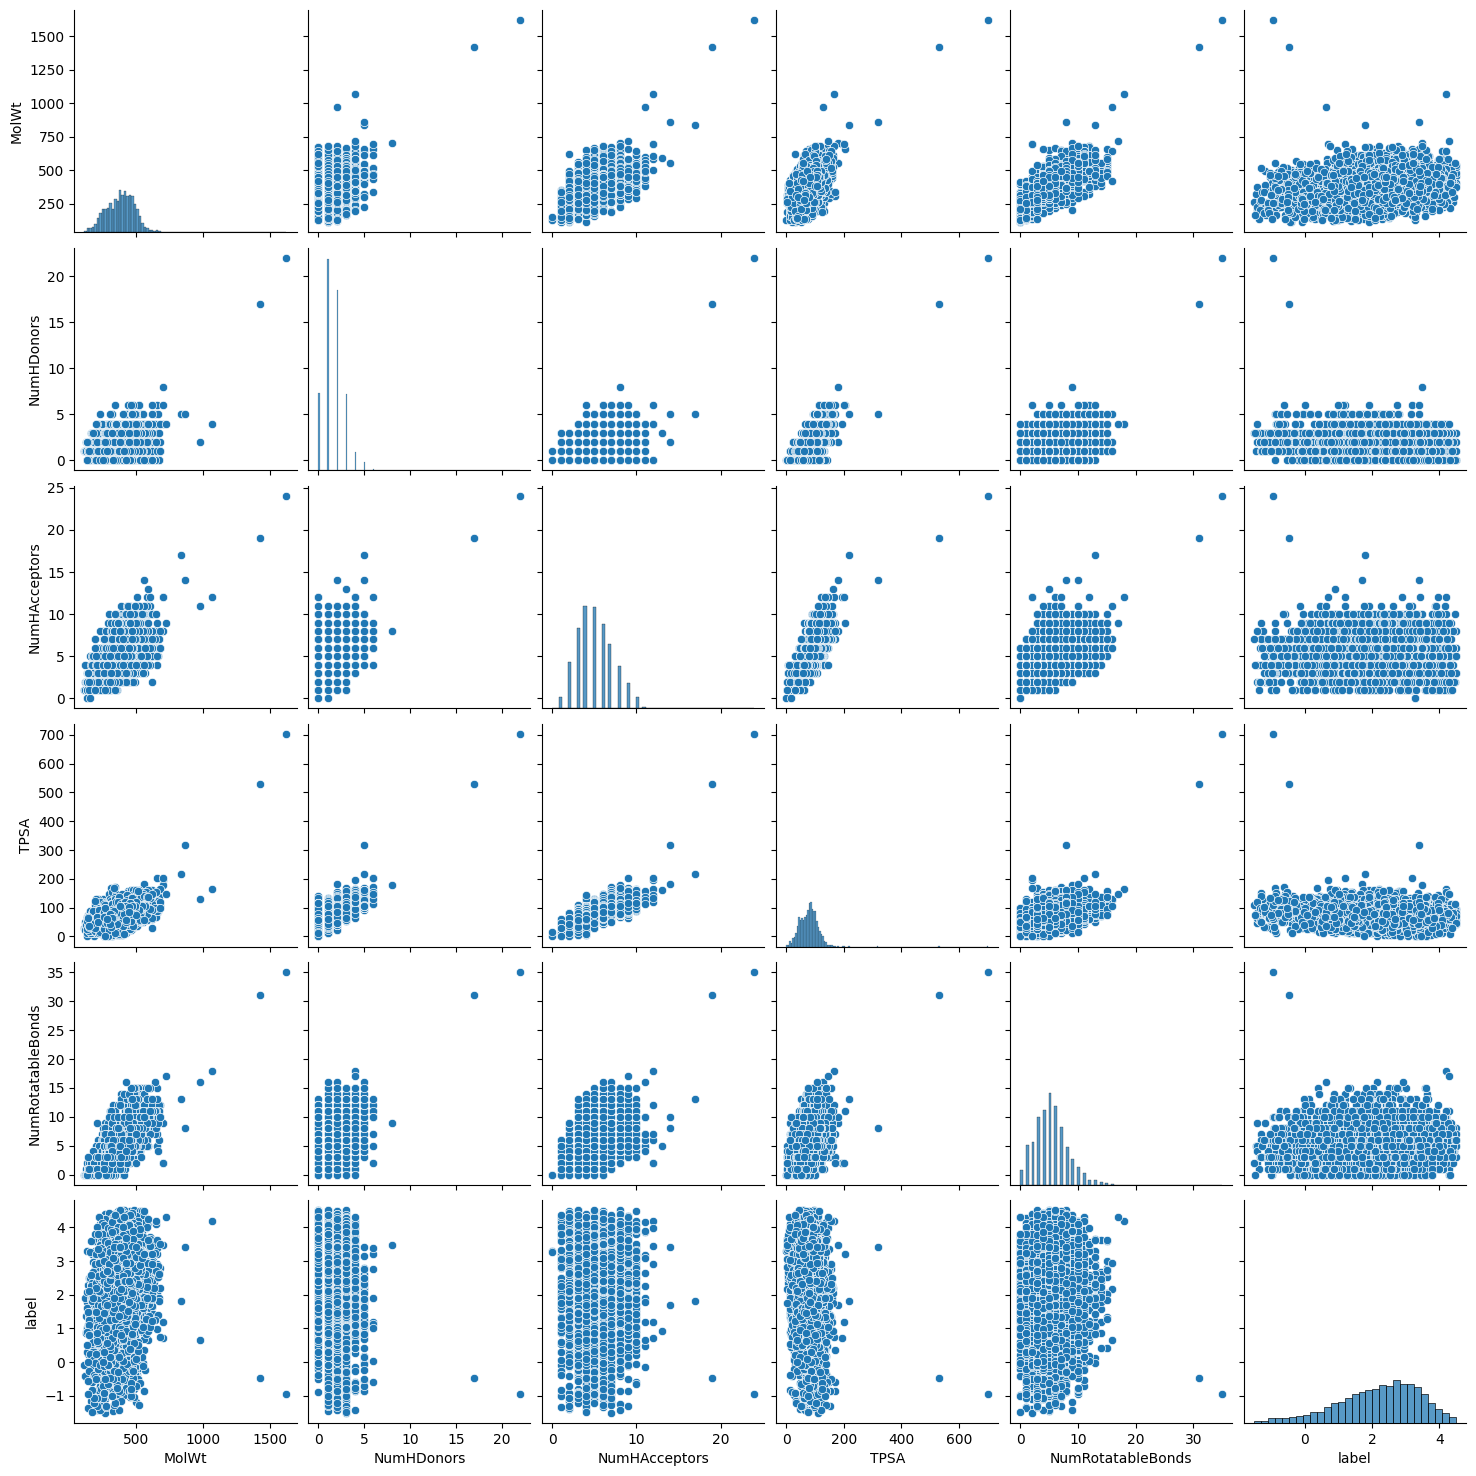

In [17]:
import pandas as pd
from rdkit.Chem import Descriptors

# Calculate multiple descriptors
data = []
for smiles in dataset['train']['SMILES']:
    mol = Chem.MolFromSmiles(smiles)
    data.append([
        Descriptors.MolWt(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.TPSA(mol),  # Topological polar surface area
        Descriptors.NumRotatableBonds(mol)
    ])

df = pd.DataFrame(data, columns=['MolWt', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds'])
df['label'] = dataset['train']['label']

# Pair plot
sns.pairplot(df)
plt.show()

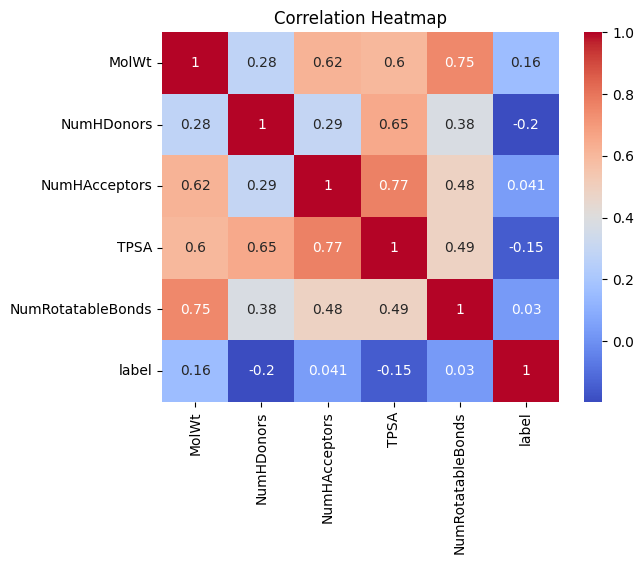

In [18]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
from torch.utils.data import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer

class SMILESDataset(Dataset):
    def __init__(self, smiles_list, targets, tokenizer_name="ibm/MoLFormer-XL-both-10pct", max_length=128):
        self.smiles_list = smiles_list
        self.targets = targets
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, trust_remote_code=True)
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        target = self.targets[idx]

        # Tokenize the SMILES string
        encoding = self.tokenizer(
            smiles,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert the target to a tensor
        target = torch.tensor(target, dtype=torch.float32)

        # Return a dictionary with the required keys
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),  # Remove batch dimension
            'target': target
        }

## --- Step 2: Split Dataset ---

As there is only one split (train split) in the original dataset, we need to split the data into training and testing sets by ourselves.

In [20]:
# tokenize the data
# load a pre-trained tokenizer from HuggingFace
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [21]:
from sklearn.model_selection import train_test_split

df = load_dataset("scikit-fingerprints/MoleculeNet_Lipophilicity")['train'].to_pandas()
print(df.columns)

# Extract the SMILES and target values
smiles_list = df['SMILES'].tolist()  # Use 'smiles' column for SMILES strings
targets = df['label'].tolist()  # Use 'exp' column for target values (lipophilicity)

# Split the dataset into training and testing sets (80% train, 20% test)
train_smiles, test_smiles, train_targets, test_targets = train_test_split(
    smiles_list, targets, test_size=0.2, random_state=42
)

# Print the sizes of the splits
print(f"Training Set: {len(train_smiles)} samples")
print(f"Testing Set: {len(test_smiles)} samples")

Index(['SMILES', 'label'], dtype='object')
Training Set: 3360 samples
Testing Set: 840 samples


In [22]:
from torch.utils.data import DataLoader

# Create the dataset
train_dataset = SMILESDataset(train_smiles, train_targets)
test_dataset = SMILESDataset(test_smiles, test_targets)

# Create the DataLoader
BATCH_SIZE = 16  # Adjust based on memory constraints
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
# Create a sample dataset
sample_dataset = SMILESDataset(train_smiles[:5], train_targets[:5])

# Check the output of __getitem__
sample_item = sample_dataset[0]
print(sample_item.keys())  # Should print: dict_keys(['input_ids', 'attention_mask', 'target'])

dict_keys(['input_ids', 'attention_mask', 'target'])


In [24]:
# Inspect a batch from the DataLoader
for batch in train_loader:
    print(batch.keys())  # Should print: dict_keys(['input_ids', 'attention_mask', 'target'])
    break

dict_keys(['input_ids', 'attention_mask', 'target'])


## --- Step 3: Load Model ---

In [25]:
from transformers import AutoModel

# Specify dataset name and model name
DATASET_PATH = "scikit-fingerprints/MoleculeNet_Lipophilicity"
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  # MoLFormer model

# Load pre-trained model from HuggingFace
model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True)

# Print the model architecture
print(model)

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

configuration_molformer.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- configuration_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_molformer.py:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- modeling_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/187M [00:00<?, ?B/s]

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

In [26]:
import torch.nn as nn
from transformers import AutoModel

class MoLFormerWithRegressionHead(nn.Module):
    def __init__(self, model_name, hidden_size=768, num_layers=1, dropout=0.1):
        """
        Args:
            model_name (str): Name of the pre-trained MoLFormer model.
            hidden_size (int): Size of the hidden layer in the regression head.
            num_layers (int): Number of fully connected layers in the regression head.
            dropout (float): Dropout probability for regularization.
        """
        super(MoLFormerWithRegressionHead, self).__init__()

        # Load the pre-trained MoLFormer model
        self.molformer = AutoModel.from_pretrained(model_name, trust_remote_code=True)

        # Freeze the MoLFormer model (optional, for fine-tuning)
        for param in self.molformer.parameters():
            param.requires_grad = False

        # Define the regression head
        self.regression_head = nn.Sequential(
            nn.Linear(self.molformer.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # Output a single value for regression
        )

    def forward(self, input_ids, attention_mask):
        """
        Args:
            input_ids (torch.Tensor): Tokenized input IDs.
            attention_mask (torch.Tensor): Attention mask for the input.

        Returns:
            torch.Tensor: Predicted regression value.
        """
        # Pass the input through the MoLFormer model
        outputs = self.molformer(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the last hidden state (CLS token or pooled output)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        cls_token = last_hidden_state[:, 0, :]  # Use the CLS token for regression

        # Pass the CLS token through the regression head
        prediction = self.regression_head(cls_token)

        return prediction

In [27]:
# Initialize the regression model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Pass the model name as a string
MODEL_NAME = "ibm/MoLFormer-XL-both-10pct"  # MoLFormer model name
regression_model = MoLFormerWithRegressionHead(MODEL_NAME).to(device)

# Print the model architecture
print(regression_model)

MoLFormerWithRegressionHead(
  (molformer): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

## --- Step 4: Training ---

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(regression_model.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Training parameters
NUM_EPOCHS = 20  # Adjust based on your dataset size and convergence
BATCH_SIZE = 32  # Adjust based on memory constraints

# Training loop
for epoch in range(NUM_EPOCHS):
    regression_model.train()  # Set the model to training mode
    epoch_loss = 0.0

    # Iterate over the training data
    for batch in train_loader:
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = regression_model(input_ids, attention_mask)

        # Compute the loss
        loss = criterion(predictions.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Print the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}")

    # Evaluate on the test set after each epoch
    regression_model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in test_loader:
            # Move data to the appropriate device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['target'].to(device)

            # Forward pass
            predictions = regression_model(input_ids, attention_mask)

            # Compute the loss
            loss = criterion(predictions.squeeze(), targets)
            test_loss += loss.item()

            # Store predictions and targets for evaluation
            all_predictions.extend(predictions.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute evaluation metrics
    avg_test_loss = test_loss / len(test_loader)
    mse = mean_squared_error(all_targets, all_predictions)
    print(f"Test Loss: {avg_test_loss:.4f}, Test MSE: {mse:.4f}")

# Save the trained model
torch.save(regression_model.state_dict(), "./models/molformer_regression_model.pth")

Epoch [1/20], Loss: 1.4316
Test Loss: 1.1017, Test MSE: 1.0862
Epoch [2/20], Loss: 1.0115
Test Loss: 0.9809, Test MSE: 0.9693
Epoch [3/20], Loss: 0.9471
Test Loss: 0.9127, Test MSE: 0.9010
Epoch [4/20], Loss: 0.8815
Test Loss: 0.8876, Test MSE: 0.8765
Epoch [5/20], Loss: 0.8509
Test Loss: 0.8246, Test MSE: 0.8138
Epoch [6/20], Loss: 0.8251
Test Loss: 0.8275, Test MSE: 0.8158
Epoch [7/20], Loss: 0.7714
Test Loss: 0.7826, Test MSE: 0.7717
Epoch [8/20], Loss: 0.7501
Test Loss: 0.7680, Test MSE: 0.7570
Epoch [9/20], Loss: 0.7564
Test Loss: 0.7812, Test MSE: 0.7675
Epoch [10/20], Loss: 0.7067
Test Loss: 0.8058, Test MSE: 0.7956
Epoch [11/20], Loss: 0.6714
Test Loss: 0.8000, Test MSE: 0.7888
Epoch [12/20], Loss: 0.6759
Test Loss: 0.7457, Test MSE: 0.7339
Epoch [13/20], Loss: 0.6339
Test Loss: 0.7120, Test MSE: 0.7011
Epoch [14/20], Loss: 0.6311
Test Loss: 0.6965, Test MSE: 0.6856
Epoch [15/20], Loss: 0.6140
Test Loss: 0.7020, Test MSE: 0.6914
Epoch [16/20], Loss: 0.6005
Test Loss: 0.6968, Te

## --- Step 5: Evaluation ---

In [29]:
# TODO: your code goes here

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Set the model to evaluation mode
regression_model.eval()

# Lists to store predictions and targets
all_predictions = []
all_targets = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Forward pass
        predictions = regression_model(input_ids, attention_mask)

        # Store predictions and targets
        all_predictions.extend(predictions.squeeze().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate evaluation metrics
mse = mean_squared_error(all_targets, all_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.7154
Root Mean Squared Error (RMSE): 0.8458
Mean Absolute Error (MAE): 0.6437
R² Score: 0.5158


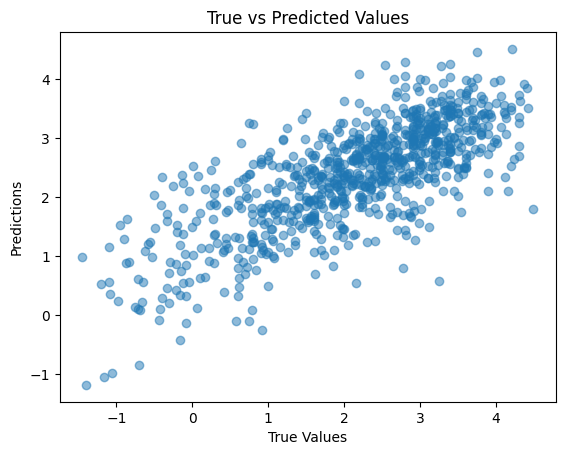

In [30]:
import matplotlib.pyplot as plt

plt.scatter(all_targets, all_predictions, alpha=0.5)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Predicted Values")
plt.show()

In [31]:
import pandas as pd

results = pd.DataFrame({
    'True Values': all_targets,
    'Predictions': all_predictions
})
results.to_csv("./outputs/predictions.csv", index=False)

# 2.Add Unsupervised Finetuning
In this step, you will perform unsupervised fine-tuning on the training dataset. This means the model will leverage only the SMILES strings without any corresponding labels to adapt its understanding of the data distribution. By familiarizing the model with the patterns and structure of the SMILES strings, you can potentially enhance its performance on downstream supervised tasks.

For this fine-tuning, you will use the Masked Language Modeling (MLM) objective, where the model learns to predict randomly masked tokens within the input sequence. Remember to save the fine-tuned model for later use.


In [32]:
# TODO: your code goes here

from transformers import AutoTokenizer, DataCollatorForLanguageModeling
from torch.utils.data import Dataset, DataLoader

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)

# Define a dataset class for unsupervised fine-tuning
class MLMDataset(Dataset):
    def __init__(self, smiles_list, tokenizer, max_length=128):
        self.smiles_list = smiles_list
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        smiles = self.smiles_list[idx]
        encoding = self.tokenizer(
            smiles,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),  # Remove batch dimension
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

# Create the MLM dataset
mlm_dataset = MLMDataset(train_smiles, tokenizer)

# Create a data collator for MLM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,  # Enable MLM
    mlm_probability=0.15  # Probability of masking a token
)

# Create the DataLoader
mlm_loader = DataLoader(mlm_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)

In [33]:
from transformers import AutoModelForMaskedLM

# Load the pre-trained MoLFormer model for MLM
mlm_model = AutoModelForMaskedLM.from_pretrained("ibm/MoLFormer-XL-both-10pct", trust_remote_code=True)
mlm_model.to(device)  # Move the model to the appropriate device

MolformerForMaskedLM(
  (molformer): MolformerModel(
    (embeddings): MolformerEmbeddings(
      (word_embeddings): Embedding(2362, 768, padding_idx=2)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): MolformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x MolformerLayer(
          (attention): MolformerAttention(
            (self): MolformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (rotary_embeddings): MolformerRotaryEmbedding()
              (feature_map): MolformerFeatureMap(
                (kernel): ReLU()
              )
            )
            (output): MolformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
         

In [34]:
from torch.optim import AdamW
from tqdm import tqdm

# Define the optimizer
optimizer = AdamW(mlm_model.parameters(), lr=5e-5)

# Training loop for MLM fine-tuning
NUM_EPOCHS = 20  # Adjust based on your needs
for epoch in range(NUM_EPOCHS):
    mlm_model.train()  # Set the model to training mode
    epoch_loss = 0.0

    # Iterate over the training data
    for batch in tqdm(mlm_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}"):
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)  # Labels are the original tokens (with masked tokens)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = mlm_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Print the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(mlm_loader)
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}")

Epoch 1/20: 100%|██████████| 210/210 [00:44<00:00,  4.68it/s]


Epoch [1/20], Loss: 0.3049


Epoch 2/20: 100%|██████████| 210/210 [00:44<00:00,  4.77it/s]


Epoch [2/20], Loss: 0.2010


Epoch 3/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [3/20], Loss: 0.1872


Epoch 4/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [4/20], Loss: 0.1578


Epoch 5/20: 100%|██████████| 210/210 [00:44<00:00,  4.76it/s]


Epoch [5/20], Loss: 0.1523


Epoch 6/20: 100%|██████████| 210/210 [00:44<00:00,  4.76it/s]


Epoch [6/20], Loss: 0.1467


Epoch 7/20: 100%|██████████| 210/210 [00:44<00:00,  4.76it/s]


Epoch [7/20], Loss: 0.1397


Epoch 8/20: 100%|██████████| 210/210 [00:44<00:00,  4.76it/s]


Epoch [8/20], Loss: 0.1376


Epoch 9/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [9/20], Loss: 0.1308


Epoch 10/20: 100%|██████████| 210/210 [00:44<00:00,  4.74it/s]


Epoch [10/20], Loss: 0.1334


Epoch 11/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [11/20], Loss: 0.1230


Epoch 12/20: 100%|██████████| 210/210 [00:44<00:00,  4.74it/s]


Epoch [12/20], Loss: 0.1252


Epoch 13/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [13/20], Loss: 0.1139


Epoch 14/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [14/20], Loss: 0.1150


Epoch 15/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [15/20], Loss: 0.1096


Epoch 16/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [16/20], Loss: 0.1151


Epoch 17/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]


Epoch [17/20], Loss: 0.1100


Epoch 18/20: 100%|██████████| 210/210 [00:44<00:00,  4.76it/s]


Epoch [18/20], Loss: 0.1120


Epoch 19/20: 100%|██████████| 210/210 [00:44<00:00,  4.74it/s]


Epoch [19/20], Loss: 0.0991


Epoch 20/20: 100%|██████████| 210/210 [00:44<00:00,  4.75it/s]

Epoch [20/20], Loss: 0.1026


In [41]:
# TODO: your code goes here

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Set the model to evaluation mode
mlm_model.eval()

# Lists to store predictions and targets
all_predictions_mlm = []
all_targets_mlm = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Forward pass
        predictions = regression_model(input_ids, attention_mask)

        # Store predictions and targets
        all_predictions_mlm.extend(predictions.squeeze().cpu().numpy())
        all_targets_mlm.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions_mlm = np.array(all_predictions_mlm)
all_targets_mlm = np.array(all_targets_mlm)

# Calculate evaluation metrics
mse_mlm = mean_squared_error(all_targets_mlm, all_predictions_mlm)
rmse_mlm = np.sqrt(mse_mlm)
mae_mlm = mean_absolute_error(all_targets_mlm, all_predictions_mlm)
r2_mlm = r2_score(all_targets_mlm, all_predictions_mlm)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse_mlm:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_mlm:.4f}")
print(f"Mean Absolute Error (MAE): {mae_mlm:.4f}")
print(f"R² Score: {r2_mlm:.4f}")

Mean Squared Error (MSE): 0.6154
Root Mean Squared Error (RMSE): 0.7845
Mean Absolute Error (MAE): 0.6053
R² Score: 0.5835


In [35]:
# Save the fine-tuned model
mlm_model.save_pretrained("./models/mlm_finetuned_molformer")
tokenizer.save_pretrained("./models/mlm_finetuned_tokenizer")

('/content/drive/MyDrive/University of Saarland/NNTI/Project_Files/notebooks/Task_1_mlm_finetuned_molformer_tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/University of Saarland/NNTI/Project_Files/notebooks/Task_1_mlm_finetuned_molformer_tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/University of Saarland/NNTI/Project_Files/notebooks/Task_1_mlm_finetuned_molformer_tokenizer/vocab.json',
 '/content/drive/MyDrive/University of Saarland/NNTI/Project_Files/notebooks/Task_1_mlm_finetuned_molformer_tokenizer/added_tokens.json',
 '/content/drive/MyDrive/University of Saarland/NNTI/Project_Files/notebooks/Task_1_mlm_finetuned_molformer_tokenizer/tokenizer.json')

In [36]:
from transformers import AutoModel

# Load the fine-tuned model
fine_tuned_model = AutoModel.from_pretrained("./models/mlm_finetuned_molformer", trust_remote_code=True)
fine_tuned_model.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

# 3.Fine-Tune for Comparison
After performing unsupervised fine-tuning on the training data, we now fine-tune the model on the regression task with the regression head. By comparing the performance of the model before and after unsupervised fine-tuning, you can evaluate how the unsupervised fine-tuning impacts the model's performance on our target task.


In [37]:
# TODO: your code goes here
from transformers import AutoModel

# Load the fine-tuned model
fine_tuned_model = AutoModel.from_pretrained("./models/mlm_finetuned_molformer", trust_remote_code=True)
fine_tuned_model.to(device)

MolformerModel(
  (embeddings): MolformerEmbeddings(
    (word_embeddings): Embedding(2362, 768, padding_idx=2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): MolformerEncoder(
    (layer): ModuleList(
      (0-11): 12 x MolformerLayer(
        (attention): MolformerAttention(
          (self): MolformerSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (rotary_embeddings): MolformerRotaryEmbedding()
            (feature_map): MolformerFeatureMap(
              (kernel): ReLU()
            )
          )
          (output): MolformerSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (in

In [38]:
import torch.nn as nn

class FineTunedRegressionModel(nn.Module):
    def __init__(self, base_model, hidden_size=768, num_layers=1, dropout=0.1):
        super(FineTunedRegressionModel, self).__init__()
        self.base_model = base_model

        # Freeze the base model (optional, for fine-tuning)
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Define the regression head
        self.regression_head = nn.Sequential(
            nn.Linear(self.base_model.config.hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1)  # Output a single value for regression
        )

    def forward(self, input_ids, attention_mask):
        # Pass the input through the base model
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the last hidden state (CLS token or pooled output)
        last_hidden_state = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_size)
        cls_token = last_hidden_state[:, 0, :]  # Use the CLS token for regression

        # Pass the CLS token through the regression head
        prediction = self.regression_head(cls_token)

        return prediction

# Initialize the fine-tuned regression model
regression_model = FineTunedRegressionModel(fine_tuned_model).to(device)

In [39]:
from torch.optim import Adam
from sklearn.metrics import mean_squared_error

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = Adam(regression_model.parameters(), lr=1e-4)  # Adjust learning rate as needed

# Training parameters
NUM_EPOCHS = 20  # Adjust based on your dataset size and convergence
BATCH_SIZE = 32  # Adjust based on memory constraints

# Training loop
for epoch in range(NUM_EPOCHS):
    regression_model.train()  # Set the model to training mode
    epoch_loss = 0.0

    # Iterate over the training data
    for batch in train_loader:
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = regression_model(input_ids, attention_mask)

        # Compute the loss
        loss = criterion(predictions.squeeze(), targets)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate the loss
        epoch_loss += loss.item()

    # Print the average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_epoch_loss:.4f}")

Epoch [1/20], Loss: 1.1961
Epoch [2/20], Loss: 0.8898
Epoch [3/20], Loss: 0.8243
Epoch [4/20], Loss: 0.7584
Epoch [5/20], Loss: 0.7295
Epoch [6/20], Loss: 0.6901
Epoch [7/20], Loss: 0.6710
Epoch [8/20], Loss: 0.6641
Epoch [9/20], Loss: 0.6207
Epoch [10/20], Loss: 0.5788
Epoch [11/20], Loss: 0.5880
Epoch [12/20], Loss: 0.5744
Epoch [13/20], Loss: 0.5555
Epoch [14/20], Loss: 0.5128
Epoch [15/20], Loss: 0.5155
Epoch [16/20], Loss: 0.5219
Epoch [17/20], Loss: 0.5092
Epoch [18/20], Loss: 0.4923
Epoch [19/20], Loss: 0.4855
Epoch [20/20], Loss: 0.4658


In [40]:
# Set the model to evaluation mode
regression_model.eval()

# Lists to store predictions and targets
all_predictions = []
all_targets = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the appropriate device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['target'].to(device)

        # Forward pass
        predictions = regression_model(input_ids, attention_mask)

        # Store predictions and targets
        all_predictions.extend(predictions.squeeze().cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Calculate evaluation metrics
mse = mean_squared_error(all_targets, all_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets, all_predictions)
r2 = r2_score(all_targets, all_predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 0.5905
Root Mean Squared Error (RMSE): 0.7684
Mean Absolute Error (MAE): 0.5980
R² Score: 0.6004
